Create 2D mesh data member for crystal class: issue #10
https://github.com/radiasoft/rslaser/issues/10

Note: I did not create a params dict or any of that because I was unsure how this mesh would get "user values"

_________________
Imports

In [1]:
import sys, time
import math
import numpy as np
from pykern import pkcli
from pykern.pkcollections import PKDict

# The rslaser library may not be installed, so a check is required.
try:
    import rslaser
except:
    # Developers should use 'pip install -e .' from the command line.
    # Users can install directly from GitHub --
    !{sys.executable} -m pip install git+https://github.com/radiasoft/rslaser.git
    import rslaser

from rslaser.pulse import pulse
from rslaser.optics import element

import scipy.constants as const
from scipy.interpolate import RectBivariateSpline

import srwlib
from srwlib import srwl

# 2D plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

# reset the notebook style
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

______________
Set laser defaults

In [2]:
# specify parameters
_LASER_PULSE_SLICE_DEFAULTS = PKDict(
    sigx_waist=10.0e-6,  
    sigy_waist=10.0e-6, 
    num_sig_trans=3,
)

_LASER_PULSE_DEFAULTS = PKDict(
        photon_e_ev=1.5498, # Photon energy [eV], calculated from 800nm wavelength
        pulseE=0.001,
        w0=128.9e-6,
        a0=0.01,
        tau_fwhm=0.3e-13,
        slice_params=_LASER_PULSE_SLICE_DEFAULTS,
)

# Instantiate the default parameters
params = _LASER_PULSE_DEFAULTS.copy()

___________
Instantiate the laser pulse

In [3]:
thisPulse = pulse.LaserPulse(params)

______________
Define a simple lattice

In [4]:
# instantiate a drift
L_drift = 0.50  # [m]
e_drift = element.Drift(L_drift)

# instantiate the crystal
crystal_params = PKDict(length = 0.01,  # [m]
                        nslice = 1,
                        )
e_crystal = element.Crystal(crystal_params)

# define a simple lattice
lattice = [(e_drift,'default'), 
           (e_crystal,'n0n2_srw'), 
           (e_drift,'default')
          ]

______________
Propagate

In [5]:
# Propagate the pulse through the lattice
for iterator in lattice:
    current_elem, prop_type = iterator
    thisPulse = current_elem.propagate(thisPulse, prop_type)

prop_type = n0n2_srw
n0: 1.75, n2: 1.75
Propagated pulse slice  1  of  3
Propagated pulse slice  2  of  3
Propagated pulse slice  3  of  3


______________
Plot the CrystalSlice.sigma_mesh for the single slice

Text(0.5, 1.0, 'Excited State Density - After Propagation')

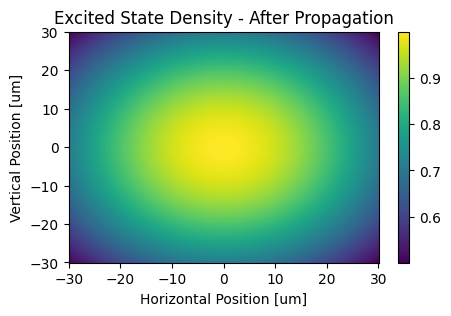

In [6]:
slice = e_crystal.slice[0]

x = np.linspace(slice.sigma_xstart,slice.sigma_xfin,slice.sigma_nx)
y = np.linspace(slice.sigma_ystart,slice.sigma_yfin,slice.sigma_ny)
    
# plot the excited state density
fig = plt.figure(figsize=(5,3))
ax = fig.gca()
plt.pcolormesh(x*1e6, y*1e6, slice.sigma_mesh, cmap=plt.cm.viridis,shading='auto')#,vmin=0.95,vmax=1.05)
plt.colorbar()
ax.set_ylabel(r'Vertical Position [um]')
ax.set_xlabel(r'Horizontal Position [um]')
ax.set_title('Excited State Density - After Propagation')

________________
For comparison, create ExcitedStates object containing 2d mesh of excited state density (sigma) for comparison

In [7]:
class ExcitedStates():
    
    def __init__(self, params=None):
        self.nx = params.nx
        self.ny = params.ny
        self.xStart = params.xStart
        self.xFin = params.xFin
        self.yStart = params.yStart
        self.yFin = params.yFin
        
        x = np.linspace(self.xStart,self.xFin,self.nx)
        y = np.linspace(self.yStart,self.yFin,self.ny)
        xv, yv = np.meshgrid(x, y)
        self.mesh = np.exp(-(xv**2.0 + yv**2.0)/((self.xFin-self.xStart)/4.0)**2.0)

    # Scale the excited states mesh to match the pulse wavefront params
    # For increaing the mesh size: use values of zero
    def _scale(self, lp_wfr):       # Assumes wfr xFin, yFin > 0 and xStart, yStart < 0
        
        dx = (self.xFin - self.xStart)/self.nx
        dy = (self.yFin - self.yStart)/self.ny
        nx_init = self.nx
        ny_init = self.ny
        
        # Update nx, ny, xFin, yFin
        d_xFin = (lp_wfr.mesh.xFin - self.xFin)
        if d_xFin != 0.0:
            self.nx += math.ceil(d_xFin/dx)
            self.xFin += math.ceil(d_xFin/dx)*dx

        d_yFin = (lp_wfr.mesh.yFin - self.yFin)
        if d_yFin != 0.0:
            self.ny += math.ceil(d_yFin/dy)
            self.yFin += math.ceil(d_yFin/dy)*dy
     
        # Change the mesh itself
        if d_xFin > 0:         # Add rows to the end of the mesh
            self.mesh = np.append(self.mesh, np.zeros((math.ceil(d_xFin/dx),np.shape(self.mesh)[1])), axis=0)
        elif d_xFin < 0:       # Remove rows from the end of the mesh
            self.mesh = np.delete(self.mesh, np.s_[self.nx:nx_init], axis=0)    
            
        if d_yFin > 0:         # Add columns to the end of the mesh
            self.mesh = np.append(self.mesh, np.zeros((np.shape(self.mesh)[0],math.ceil(d_yFin/dy))), axis=1)
        elif d_yFin < 0:       # Delete columns from the end of the mesh
            self.mesh = np.delete(self.mesh, np.s_[self.ny:ny_init], axis=1)
        
        # Update nx, ny, xStart, yStart            
        d_xStart = (self.xStart - lp_wfr.mesh.xStart)
        if d_xStart != 0.0:
            self.nx += math.ceil(d_xStart/dx)
            self.xStart -= math.ceil(d_xStart/dx)*dx
        
        d_yStart = (self.yStart - lp_wfr.mesh.yStart)
        if d_yStart != 0.0:
            self.ny += math.ceil(d_yStart/dy)
            self.yStart -= math.ceil(d_yStart/dy)*dy
            
        # Change the mesh itself           
        if d_xStart > 0:       # Add rows to the start of the mesh
            self.mesh = np.append(np.zeros((math.ceil(d_xStart/dx),np.shape(self.mesh)[1])), self.mesh, axis=0)
        elif d_xStart < 0:     # Delete rows from the start of the mesh
            self.mesh = np.delete(self.mesh, np.s_[0:-math.ceil(d_xStart/dx)], axis=0)
            
        if d_yStart > 0:       # Add columns to the start of the mesh
            self.mesh = np.append(np.zeros((np.shape(self.mesh)[0],math.ceil(d_yStart/dy))), self.mesh, axis=1)
        elif d_yStart < 0:     # Delete columns from the start of the mesh
            self.mesh = np.delete(self.mesh,  np.s_[0:-math.ceil(d_yStart/dy)], axis=1)

    # Interpolate the excited states mesh to match the pulse wavefront params
    def interpolate(self, lp_wfr):
        
        self._scale(lp_wfr)
            
        # check if n cells matches
        
        excited_states_x = np.linspace(self.xStart,self.xFin,self.nx)
        excited_states_y = np.linspace(self.yStart,self.yFin,self.ny)
        
        rect_biv_spline = RectBivariateSpline(excited_states_x, excited_states_y, self.mesh)
        
        lp_wfr_x = np.linspace(lp_wfr.mesh.xStart,lp_wfr.mesh.xFin,lp_wfr.mesh.nx)
        lp_wfr_y = np.linspace(lp_wfr.mesh.yStart,lp_wfr.mesh.yFin,lp_wfr.mesh.ny)
        
        self.mesh = rect_biv_spline(lp_wfr_x, lp_wfr_y) #Evaluate the spline at points
        self.xStart = lp_wfr.mesh.xStart
        self.xFin = lp_wfr.mesh.xFin
        self.yStart = lp_wfr.mesh.yStart
        self.yFin = lp_wfr.mesh.yFin
        self.nx = np.shape(self.mesh)[0]
        self.ny = np.shape(self.mesh)[1]

_____________
Interpolating to a smaller grid: plot the mesh values before and after

Text(0.5, 1.0, 'Excited State Density - After Interpolation')

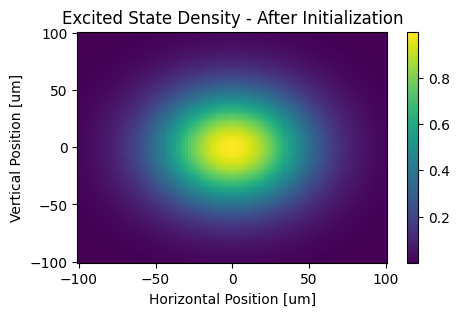

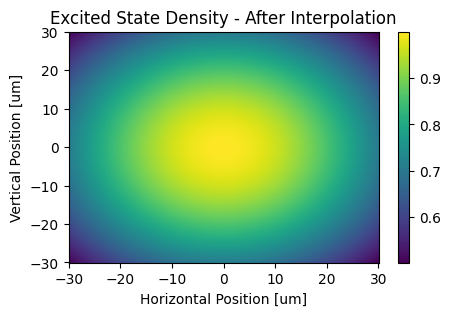

In [8]:
_EXCITED_STATES_DEFAULTS = PKDict(
        nx = 100,
        ny = 100,
        xStart = -10.0e-5, #10.0e-5
        xFin = 10.0e-5,
        yStart = -10.0e-5,
        yFin = 10.0e-5,    
)

# Instantiate the default parameters:
params = _EXCITED_STATES_DEFAULTS.copy()

thisSigma = ExcitedStates(params)
thisPulse_wfr = thisPulse.slice[0].wfr

x = np.linspace(thisSigma.xStart,thisSigma.xFin,thisSigma.nx)
y = np.linspace(thisSigma.yStart,thisSigma.yFin,thisSigma.ny)
    
# plot the excited state density
fig = plt.figure(figsize=(5,3))
ax = fig.gca()
plt.pcolormesh(x*1e6, y*1e6, thisSigma.mesh, cmap=plt.cm.viridis,shading='auto')#,vmin=0.95,vmax=1.05)
plt.colorbar()
ax.set_ylabel(r'Vertical Position [um]')
ax.set_xlabel(r'Horizontal Position [um]')
ax.set_title('Excited State Density - After Initialization')

thisSigma.interpolate(thisPulse_wfr)

x = np.linspace(thisSigma.xStart,thisSigma.xFin,thisSigma.nx)
y = np.linspace(thisSigma.yStart,thisSigma.yFin,thisSigma.ny)
    
# plot the excited state density
fig = plt.figure(figsize=(5,3))
ax = fig.gca()
plt.pcolormesh(x*1e6, y*1e6, thisSigma.mesh, cmap=plt.cm.viridis,shading='auto')#,vmin=0.95,vmax=1.05)
plt.colorbar()
ax.set_ylabel(r'Vertical Position [um]')
ax.set_xlabel(r'Horizontal Position [um]')
ax.set_title('Excited State Density - After Interpolation')


_____________
Interpolating to a larger grid: plot the mesh values before and after

Text(0.5, 1.0, 'Excited State Density - After Interpolation')

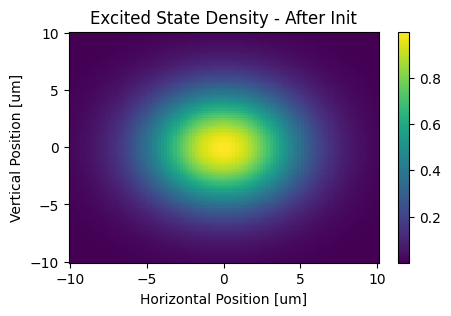

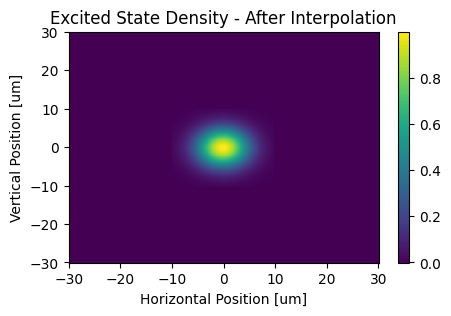

In [9]:
_EXCITED_STATES_DEFAULTS = PKDict(
        nx = 100,
        ny = 100,
        xStart = -1.0e-5, #10.0e-5
        xFin = 1.0e-5,
        yStart = -1.0e-5,
        yFin = 1.0e-5,    
)

# Instantiate the default parameters:
params = _EXCITED_STATES_DEFAULTS.copy()

thisSigma = ExcitedStates(params)
thisPulse_wfr = thisPulse.slice[0].wfr

x = np.linspace(thisSigma.xStart,thisSigma.xFin,thisSigma.nx)
y = np.linspace(thisSigma.yStart,thisSigma.yFin,thisSigma.ny)
    
# plot the excited state density
fig = plt.figure(figsize=(5,3))
ax = fig.gca()
plt.pcolormesh(x*1e6, y*1e6, thisSigma.mesh, cmap=plt.cm.viridis,shading='auto')#,vmin=0.95,vmax=1.05)
plt.colorbar()
ax.set_ylabel(r'Vertical Position [um]')
ax.set_xlabel(r'Horizontal Position [um]')
ax.set_title('Excited State Density - After Init')

thisSigma.interpolate(thisPulse_wfr)

x = np.linspace(thisSigma.xStart,thisSigma.xFin,thisSigma.nx)
y = np.linspace(thisSigma.yStart,thisSigma.yFin,thisSigma.ny)
    
# plot the excited state density
fig = plt.figure(figsize=(5,3))
ax = fig.gca()
plt.pcolormesh(x*1e6, y*1e6, thisSigma.mesh, cmap=plt.cm.viridis,shading='auto')#,vmin=0.95,vmax=1.05)
plt.colorbar()
ax.set_ylabel(r'Vertical Position [um]')
ax.set_xlabel(r'Horizontal Position [um]')
ax.set_title('Excited State Density - After Interpolation')


In [ ]:
# print('\nwfr nx: ', thisPulse_wfr.mesh.nx)
# print('wfr ny: ', thisPulse_wfr.mesh.ny)
# print('wfr xStart: ', thisPulse_wfr.mesh.xStart)
# print('wfr xFin: ', thisPulse_wfr.mesh.xFin)
# print('wfr yStart: ', thisPulse_wfr.mesh.yStart)
# print('wfr yFin: ', thisPulse_wfr.mesh.yFin)

# print('\nSigma nx: ', thisSigma.nx)
# print('Sigma ny: ', thisSigma.ny)
# print('Sigma xStart: ', thisSigma.xStart)
# print('Sigma xFin: ', thisSigma.xFin)
# print('Sigma yStart: ', thisSigma.yStart)
# print('Sigma yFin: ', thisSigma.yFin)
# print('Sigma mesh shape: ', np.shape(thisSigma.mesh))

____________
An example of if we interpolate before scaling...

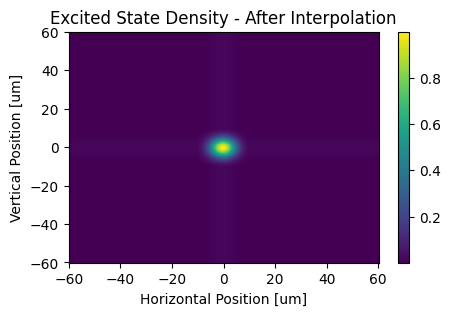